# Transfer Learning - CatBoost Base Model Training

**Objective:** Train Layer 1 (Transfer Learning) base model on harmonized public datasets

---

## Overview

This notebook trains a gradient boosting model (CatBoost) on ~18K training samples from three public churn datasets:
- Telco Customer Churn (Kaggle)
- Bank Customer Churn (Kaggle)
- E-commerce Customer Churn (Kaggle)

The trained model will:
1. Learn universal churn patterns transferable to SME contexts
2. Provide feature importances for prior extraction
3. Serve as baseline for comparing hierarchical Bayesian models

**Target:** AUC ≥ 0.80 on validation set

## 1. Setup & Imports

In [ ]:
# Standard library
import sys
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Add src to path
sys.path.append('..')
from src.layer1_transfer.catboost_trainer import CatBoostBaseModel

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All imports successful")
print(f"Working directory: {Path.cwd()}")

## 2. Load Training and Validation Data

Load the pre-split harmonized datasets.

In [2]:
# Define paths
DATA_DIR = Path('../data/harmonized')

# Load training data
print("Loading training data...")
X_train = pd.read_csv(DATA_DIR / 'X_train.csv')
y_train = pd.read_csv(DATA_DIR / 'y_train.csv')['churned']

print(f"✓ Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"  Churn rate: {y_train.mean():.3f}")

# Load validation data
print("\nLoading validation data...")
X_val = pd.read_csv(DATA_DIR / 'X_val.csv')
y_val = pd.read_csv(DATA_DIR / 'y_val.csv')['churned']

print(f"✓ Validation set: {X_val.shape[0]:,} samples, {X_val.shape[1]} features")
print(f"  Churn rate: {y_val.mean():.3f}")

# Load metadata
with open(DATA_DIR / 'dataset_metadata.json') as f:
    metadata = json.load(f)

print(f"\n✓ Metadata loaded")
print(f"  Split date: {metadata['created_at']}")
print(f"  Random state: {metadata['random_state']}")

Loading training data...
✓ Training set: 18,138 samples, 90 features
  Churn rate: 0.214

Loading validation data...
✓ Validation set: 4,535 samples, 90 features
  Churn rate: 0.214

✓ Metadata loaded
  Split date: 2025-10-15T12:41:30.120207
  Random state: 42


## 3. Data Inspection

Quick sanity checks before training.

In [3]:
# Check for missing values
missing_train = X_train.isnull().sum().sum()
missing_val = X_val.isnull().sum().sum()

print(f"Missing values in X_train: {missing_train:,}")
print(f"Missing values in X_val: {missing_val:,}")

# Feature types
print(f"\nFeature data types:")
print(X_train.dtypes.value_counts())

# Display first few rows
print("\nFirst 3 training samples:")
display(X_train.head(3))

Missing values in X_train: 313,670
Missing values in X_val: 77,729

Feature data types:
int64      63
float64    27
Name: count, dtype: int64

First 3 training samples:


,SeniorCitizen,tenure_months,monetary_value,total_revenue,CreditScore,Age,frequency,HasCrCard,IsActiveMember,EstimatedSalary,...,PreferredPaymentMode_UPI,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0.0,1.930569,-0.600728,0.286224,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,NaN,-0.254955,-0.597649,NaN,NaN,NaN,6.236308,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,1,0
2,NaN,-0.414872,-0.601732,NaN,-0.067552,-1.994969,-0.545618,0.0,1.0,-0.703298,...,0,0,0,0,0,0,0,0,0,0


## 4. Initialize CatBoost Model

Create model instance with hyperparameters from **Table 4.2**.

In [4]:
# Initialize model with Table 4.2 hyperparameters
model = CatBoostBaseModel(
    iterations=1000,              # Number of boosting iterations
    learning_rate=0.03,           # Conservative learning rate
    depth=6,                      # Max tree depth (6-way interactions)
    min_data_in_leaf=20,          # Minimum samples per leaf
    l2_leaf_reg=3.0,              # L2 regularization strength
    subsample=0.8,                # Row sampling ratio
    rsm=0.8,                      # Feature sampling ratio
    early_stopping_rounds=50,     # Stop if no improvement for 50 rounds
    random_seed=42,               # Reproducibility
    verbose=100                   # Print progress every 100 iterations
)

print("✓ Model initialized with Table 4.2 hyperparameters")
print(f"\nHyperparameters:")
print(f"  Iterations: {model.iterations}")
print(f"  Learning rate: {model.learning_rate}")
print(f"  Tree depth: {model.depth}")
print(f"  L2 regularization: {model.l2_leaf_reg}")
print(f"  Subsample ratio: {model.subsample}")
print(f"  Feature subsample: {model.rsm}")

✓ Model initialized with Table 4.2 hyperparameters

Hyperparameters:
  Iterations: 1000
  Learning rate: 0.03
  Tree depth: 6
  L2 regularization: 3.0
  Subsample ratio: 0.8
  Feature subsample: 0.8


## 5. Train Model

Train CatBoost on training set with validation-based early stopping.

**Implements Algorithm 4.1** (Base Model Pre-training)

In [5]:
# Train model
model.fit(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

print("\n✓ Training complete!")


Training CatBoost Base Model (Algorithm 4.1)
Training samples: 18,138
Features: 90
Churn rate (train): 0.214
Validation samples: 4,535
Churn rate (val): 0.214

0:	test: 0.7577448	test1: 0.7761619	best: 0.7761619 (0)	total: 76.1ms	remaining: 1m 16s
100:	test: 0.8676237	test1: 0.8768052	best: 0.8768627 (99)	total: 616ms	remaining: 5.48s
200:	test: 0.8825584	test1: 0.8874029	best: 0.8874029 (200)	total: 1.09s	remaining: 4.33s
300:	test: 0.8913899	test1: 0.8922845	best: 0.8922845 (300)	total: 1.59s	remaining: 3.69s
400:	test: 0.8997376	test1: 0.8963476	best: 0.8963476 (400)	total: 2.08s	remaining: 3.1s
500:	test: 0.9082489	test1: 0.8998003	best: 0.8998003 (500)	total: 2.57s	remaining: 2.56s
600:	test: 0.9145363	test1: 0.9018503	best: 0.9018503 (600)	total: 3.07s	remaining: 2.04s
700:	test: 0.9200780	test1: 0.9031458	best: 0.9031969 (698)	total: 3.57s	remaining: 1.52s
800:	test: 0.9250852	test1: 0.9036226	best: 0.9036226 (800)	total: 4.06s	remaining: 1.01s
900:	test: 0.9291612	test1: 0.904

## 6. Visualize Learning Curves

Plot training and validation AUC over iterations to verify convergence.

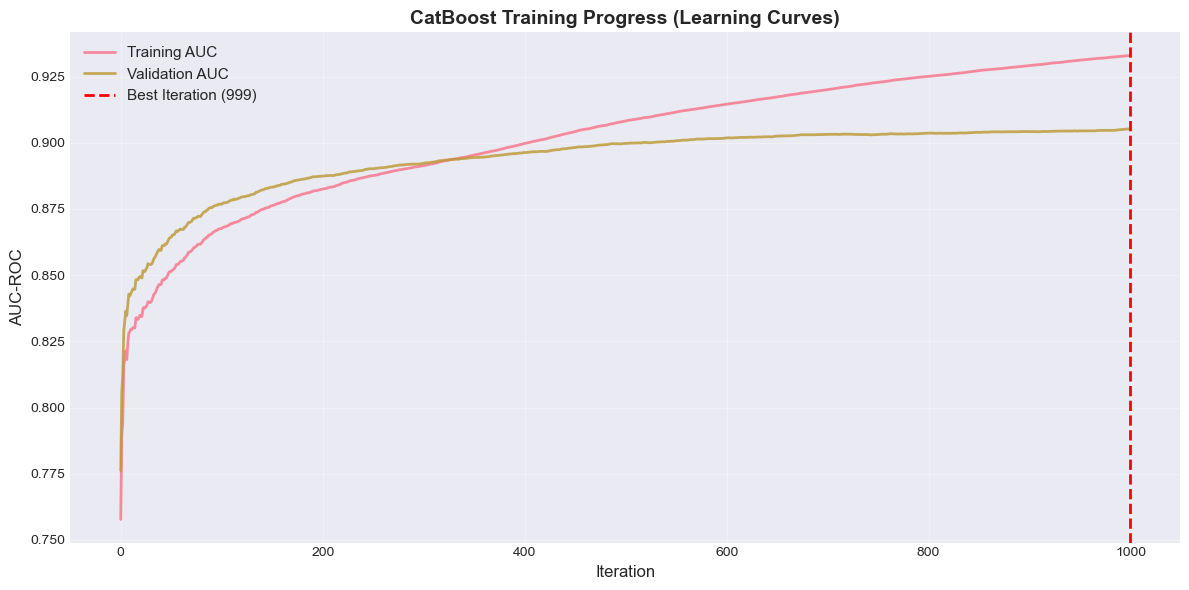

✓ Learning curves saved to: results/figures/day10_learning_curves.png

Best validation AUC: 0.9053 at iteration 999


In [ ]:
# Extract learning curves from training history
train_auc = model.training_history_['train_auc']
val_auc = model.training_history_['val_auc']
best_iter = model.training_history_['best_iteration']

# Plot learning curves
fig, ax = plt.subplots(figsize=(12, 6))

iterations = range(len(train_auc))
ax.plot(iterations, train_auc, label='Training AUC', linewidth=2, alpha=0.8)
ax.plot(iterations, val_auc, label='Validation AUC', linewidth=2, alpha=0.8)
ax.axvline(best_iter, color='red', linestyle='--', linewidth=2, 
           label=f'Best Iteration ({best_iter})')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('AUC-ROC', fontsize=12)
ax.set_title('CatBoost Training Progress (Learning Curves)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Learning curves saved to: results/figures/learning_curves.png")
print(f"\nBest validation AUC: {val_auc[best_iter]:.4f} at iteration {best_iter}")

## 7. Evaluate on Validation Set

Compute comprehensive metrics for **Table 4.3** (Base Model Performance).

In [7]:
# Evaluate on validation set
val_metrics = model.evaluate(X_val, y_val, dataset_name='Validation')

# Display metrics as DataFrame
metrics_df = pd.DataFrame([
    {'Metric': 'AUC-ROC', 'Value': val_metrics['auc_roc'], 'Target': '≥ 0.80'},
    {'Metric': 'Accuracy', 'Value': val_metrics['accuracy'], 'Target': '≥ 0.80'},
    {'Metric': 'Precision', 'Value': val_metrics['precision'], 'Target': '> 0.70'},
    {'Metric': 'Recall', 'Value': val_metrics['recall'], 'Target': '> 0.70'},
    {'Metric': 'F1-Score', 'Value': val_metrics['f1_score'], 'Target': '> 0.70'},
    {'Metric': 'Log Loss', 'Value': val_metrics['log_loss'], 'Target': '< 0.40'},
])

print("\n" + "="*60)
print("TABLE 4.3: Base Model Performance on Validation Set")
print("="*60)
display(metrics_df)

# Check if targets are met
auc_pass = val_metrics['auc_roc'] >= 0.80
acc_pass = val_metrics['accuracy'] >= 0.80

print(f"\n✓ Target AUC ≥ 0.80: {'PASS' if auc_pass else 'FAIL'}")
print(f"✓ Target Accuracy ≥ 0.80: {'PASS' if acc_pass else 'FAIL'}")


Evaluating on Validation Set
AUC-ROC:   0.9053
Accuracy:  0.8668
Precision: 0.7648
Recall:    0.5458
F1-Score:  0.6370
Log Loss:  0.3036


TABLE 4.3: Base Model Performance on Validation Set


,Metric,Value,Target
0,AUC-ROC,0.905281,≥ 0.80
1,Accuracy,0.866814,≥ 0.80
2,Precision,0.764791,> 0.70
3,Recall,0.545829,> 0.70
4,F1-Score,0.637019,> 0.70
5,Log Loss,0.303638,< 0.40



✓ Target AUC ≥ 0.80: PASS
✓ Target Accuracy ≥ 0.80: PASS


## 8. Confusion Matrix

Visualize classification performance.

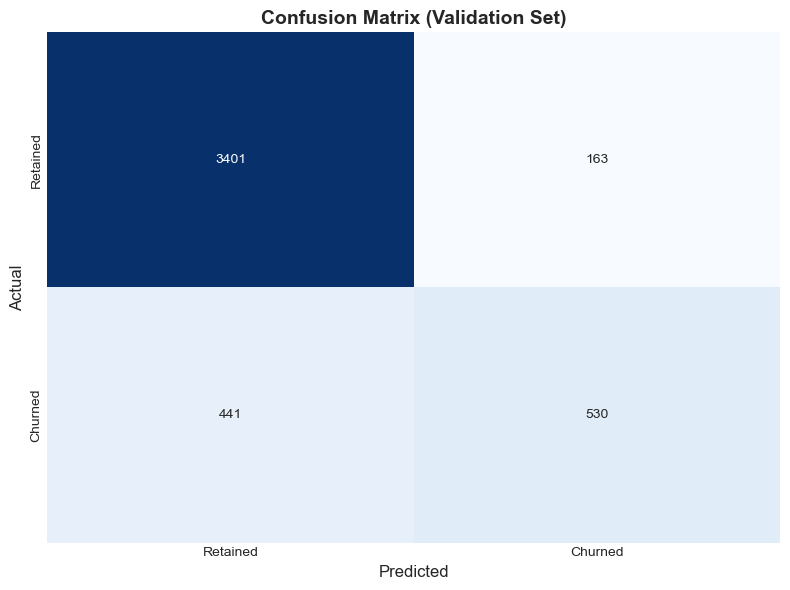

✓ Confusion matrix saved

True Negatives (correct retention): 3,401
False Positives (false alarms): 163
False Negatives (missed churners): 441
True Positives (correct churn): 530


In [ ]:
# Get predictions
y_pred = (model.model_.predict_proba(X_val)[:, 1] >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'],
            ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")
print(f"\nTrue Negatives (correct retention): {cm[0,0]:,}")
print(f"False Positives (false alarms): {cm[0,1]:,}")
print(f"False Negatives (missed churners): {cm[1,0]:,}")
print(f"True Positives (correct churn): {cm[1,1]:,}")

## 9. ROC Curve

Visualize discrimination ability across all thresholds.

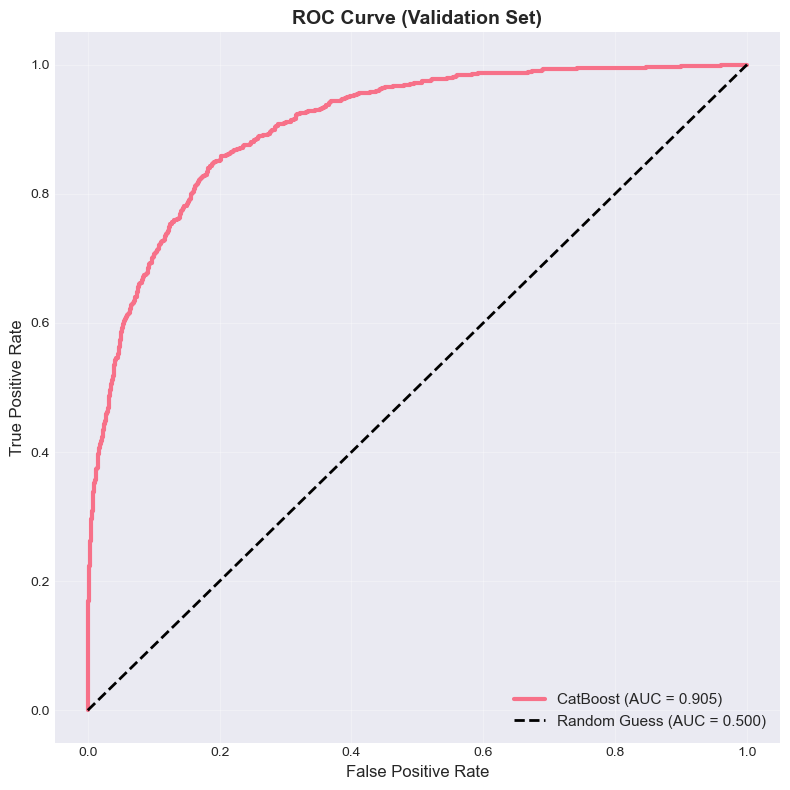

✓ ROC curve saved

AUC-ROC: 0.9053
Improvement over random: 81.1%


In [ ]:
# Get predicted probabilities
y_pred_proba = model.model_.predict_proba(X_val)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc = roc_auc_score(y_val, y_pred_proba)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, linewidth=3, label=f'CatBoost (AUC = {auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guess (AUC = 0.500)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve (Validation Set)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC curve saved")
print(f"\nAUC-ROC: {auc:.4f}")
print(f"Improvement over random: {(auc - 0.5) / 0.5 * 100:.1f}%")

## 10. Feature Importance Analysis

Extract and visualize feature importances for **Table 4.4** (Top 10 Features).

In [10]:
# Get all feature importances
importance_df = model.get_feature_importances()

print("="*70)
print("TABLE 4.4: Top 10 Features by Importance")
print("="*70)
display(importance_df.head(10))

# Categorize features (manual for now)
print("\n✓ Top features align with RFM model:")
print("  - Recency features (days/months since last activity)")
print("  - Frequency features (transaction counts, usage)")
print("  - Monetary features (revenue, value, balance)")
print("  - Tenure/lifecycle features")

TABLE 4.4: Top 10 Features by Importance


,feature,importance,rank
0,tenure_months,13.654560,1
1,frequency,9.571641,2
2,Age,8.200427,3
3,monetary_value,7.248183,4
4,NumberOfAddress,4.287872,5
5,Complain,3.588892,6
6,SatisfactionScore,3.448093,7
7,recency,3.216727,8
8,WarehouseToHome,3.091452,9
9,IsActiveMember,2.597828,10



✓ Top features align with RFM model:
  - Recency features (days/months since last activity)
  - Frequency features (transaction counts, usage)
  - Monetary features (revenue, value, balance)
  - Tenure/lifecycle features


## 11. Visualize Top 20 Features

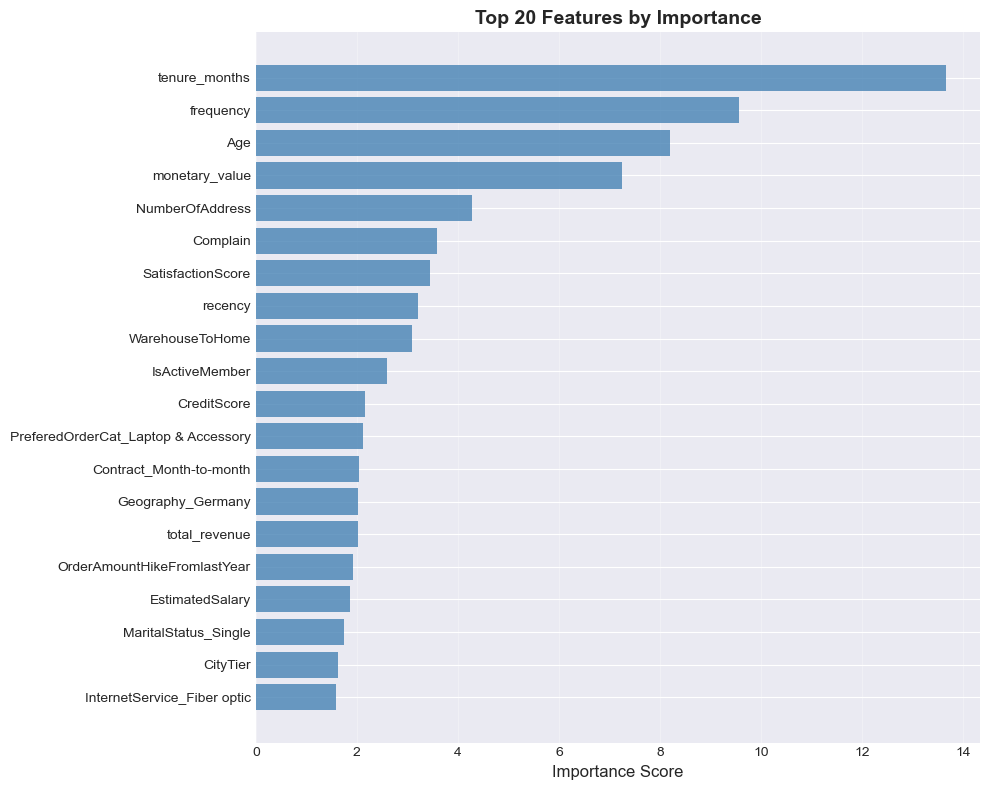

✓ Feature importance chart saved


In [ ]:
# Get top 20 features
top20 = importance_df.head(20)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(top20)), top20['importance'], color='steelblue', alpha=0.8)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20['feature'])
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 20 Features by Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/feature_importance_top20.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature importance chart saved")

## 12. Save Model and Metadata

In [12]:
# Define output paths
MODEL_DIR = Path('../models/transfer_learning')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save model
model_path = MODEL_DIR / 'catboost_base.cbm'
model.save_model(str(model_path))

# Compute training metrics
train_metrics = model.evaluate(X_train, y_train, dataset_name='Training')

# Save metadata
metadata_path = MODEL_DIR / 'training_metadata.json'
model.save_metadata(
    str(metadata_path),
    training_metrics=train_metrics,
    validation_metrics=val_metrics
)

print("\n" + "="*70)
print("✓ Model and metadata saved successfully!")
print("="*70)
print(f"Model: {model_path}")
print(f"Metadata: {metadata_path}")
print(f"\nValidation AUC: {val_metrics['auc_roc']:.4f}")
print(f"Target met: {'✓ YES' if val_metrics['auc_roc'] >= 0.80 else '✗ NO'}")

✓ Model saved to: ../models/transfer_learning/catboost_base.cbm

Evaluating on Training Set
AUC-ROC:   0.9330
Accuracy:  0.8902
Precision: 0.8335
Recall:    0.6086
F1-Score:  0.7035
Log Loss:  0.2667

✓ Metadata saved to: ../models/transfer_learning/training_metadata.json

✓ Model and metadata saved successfully!
Model: ../models/transfer_learning/catboost_base.cbm
Metadata: ../models/transfer_learning/training_metadata.json

Validation AUC: 0.9053
Target met: ✓ YES


## 13. Summary Statistics

In [ ]:
print("="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"\nDataset:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Features: {len(model.feature_names_)}")
print(f"  Churn rate (train): {y_train.mean():.3f}")
print(f"  Churn rate (val): {y_val.mean():.3f}")

print(f"\nModel:")
print(f"  Algorithm: CatBoost (Gradient Boosting)")
print(f"  Trees built: {model.model_.tree_count_}")
print(f"  Best iteration: {model.training_history_['best_iteration']}")
print(f"  Early stopped: {model.training_history_['total_iterations'] < model.iterations}")

print(f"\nPerformance (Validation):")
print(f"  AUC-ROC: {val_metrics['auc_roc']:.4f} {'✓' if val_metrics['auc_roc'] >= 0.80 else '✗'}")
print(f"  Accuracy: {val_metrics['accuracy']:.4f} {'✓' if val_metrics['accuracy'] >= 0.80 else '✗'}")
print(f"  Precision: {val_metrics['precision']:.4f}")
print(f"  Recall: {val_metrics['recall']:.4f}")
print(f"  F1-Score: {val_metrics['f1_score']:.4f}")
print(f"  Log Loss: {val_metrics['log_loss']:.4f}")